<a href="https://colab.research.google.com/github/SerejkaP/ML_Homeworks/blob/main/HW5/AI_HW5_boosting_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашняя работа: прогнозирование заработной платы и кластеризация типов движений**

### **Постановка задачи:**

В этой работе две части:

*   В первой части вам предстоит построить алгоритм на основе бустинга для прогнозирования зарплаты
*   Во второй части вам предстоит кластеризовать типы движений по имеющимся данным с акселерометров и гироскопов

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 1 бонусный балл.

Оценка за ДЗ = min{ваш балл, 10}

**Мягкий дедлайн: 16 февраля 23:59**

**Интересной вам работы!**


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import time

# **Часть 1. Прогнозирование заработной платы при помощи бустинга**

**Количество баллов:** 7

## **Постановка задачи:**

Данные выгружены и лежат в файле `ds_salary.csv`. Вам доступны описания признаков и значения целевой переменной.

**Ваша задача:** построение модели бустинга и оценка данной модели.

## **Описание даных**

- work_year: год, в который взяты данные;
- experience_level: уровень опыта, кодируемый как SE, MI EN или EX
- employment_type: тип занятости (FT, PT, CT, FL)
- job_title: название рабочей позиции в компании;
- salary: зараплата на позиции;
- salary_currency: валюта в которой начисляют зарплату;
- employee_residence: страна или регион проживания сотрудника
- remote_ratio: процент удаленки, предлагаемый в компании (0, 50, 100)
- company_location: местоположение компании
- company_size: размер компании, оцененный как S, M, L
- salary_in_usd: целевая переменная


Как всегда, загрузим набор данных.

In [ ]:
df = pd.read_csv("https://github.com/hse-ds/iad-intro-ds/raw/refs/heads/master/2023/homeworks/hw-08-boosting/ds_salaries.csv")

In [ ]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


In [ ]:
df.shape

(3755, 11)

## **Задание 1 (0.3 балла)**

Вам даны описания переменных. Проверьте, что категориальные признаки, категории которых перечислены, не имеют ошибочных значений. Для этого:

- Напишите цикл, пробегающий по выбранным признакам и оценивающий, что в них нет лишних значений;

In [ ]:
experience_levels = ['SE', 'MI', 'EN', 'EX']
employment_types = ['FT', 'PT', 'CT', 'FL']
remote_ratios = [0, 50, 100]
company_sizes = ['S', 'M', 'L']


In [ ]:
def check_extra_values(df, column_name, values):
  not_in_values = []
  for val in df[column_name].unique():
      if val not in values:
          not_in_values.append(val)
  print(f"Для {column_name} лишних значений {len(not_in_values)}")
  if not_in_values:
    print(not_in_values)

In [ ]:
check_extra_values(df, 'experience_level', experience_levels)

Для experience_level лишних значений 0


In [ ]:
check_extra_values(df, 'employment_type', employment_types)

Для employment_type лишних значений 0


In [ ]:
check_extra_values(df, 'remote_ratio', remote_ratios)

Для remote_ratio лишних значений 0


In [ ]:
check_extra_values(df, 'company_size', company_sizes)

Для company_size лишних значений 0


## **Задание 2 (0.3 балла)**

Проведите базовые шаги оценки качества данных.
- Есть есть проблемы, устраните их;
- Если нет проблем, кратко опишите это.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


In [ ]:
df.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,3755.000000,3.755000e+03,3755.000000,3755.000000
mean,2022.373635,1.906956e+05,137570.389880,46.271638
std,0.691448,6.716765e+05,63055.625278,48.589050
min,2020.000000,6.000000e+03,5132.000000,0.000000
25%,2022.000000,1.000000e+05,95000.000000,0.000000
50%,2022.000000,1.380000e+05,135000.000000,0.000000
75%,2023.000000,1.800000e+05,175000.000000,100.000000
max,2023.000000,3.040000e+07,450000.000000,100.000000


In [ ]:
df.describe(include='object')

,experience_level,employment_type,job_title,salary_currency,employee_residence,company_location,company_size
count,3755,3755,3755,3755,3755,3755,3755
unique,4,4,93,20,78,72,3
top,SE,FT,Data Engineer,USD,US,US,M
freq,2516,3718,1040,3224,3004,3040,3153


В каждом столбце 3755 записи. В данных не видно выбросов и пропусков, все значения соответствуют описанным.

## **Задание 3 (0.3 балла)**

Вернитесь к описанию признаков.
- Проверьте, все ли признаки соответствуют постановке задачи? Если есть лишние признаки, удалите их и обоснуйте удаление, если нет, сделайте вывод о релевантности (достаточно в одну-две строки)
- Зафиксируйте, в каких признаках много категорий.

In [ ]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


**Ваши выводы здесь**

Возможно, зная точные курсы валют (используя work_year, salary и salary_currency) можно было бы вычислить целевую переменную не прибегая к машинному обучению.  
Признаков, которые дублировали бы друг друга, не найдено. Данные кажутся релевантными задаче, удаление не требуется.  
Из задания 2 известно, что job_title,	salary_currency,	employee_residence,	company_location имеют много категорий:
- job_title: 93;
- salary_currency: 20;
- employee_residence: 78;
- company_location: 72;

## **Задание 4 (0.2 балла)**

Разделите выборку на train, test (80%, 20%).

In [ ]:
X = df.drop('salary_in_usd', axis=1)
y = df['salary_in_usd']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_test.shape

((3004, 10), (751, 10))

## **Задание 5 (0.3 балла)**

Будем проверять два сценария. Первый — построение модели только на непрерывных признаках, а второй — построение с категориальными. В этом задании подготовьте всё, чтобы проверить валидность обоих сценариев. А именно:

- Выделите данные для тренировки и теста для непрерывных признаков
- Выделите данные для тренировки и теста для непрерывных + категориальных признаков, пока ничего не кодируйте.

In [ ]:
categorical_columns = list(X.select_dtypes(include=['object']).columns)
categorical_columns.append('remote_ratio')

In [ ]:
X_train_continuous = X_train.drop(categorical_columns, axis=1)
X_test_continuous = X_test.drop(categorical_columns, axis=1)

In [ ]:
X_train_continuous.shape, X_test_continuous.shape

((3004, 2), (751, 2))

Для непрерывных + категориальных данные уже подготовлены в X_train, X_test

In [ ]:
X_train.shape, X_test.shape

((3004, 10), (751, 10))

## **Задание 6 (0.2 балла)**

- Обучите модель линейной регресии на числовых признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_continuous, y_train)
lr_pred_cont = lr.predict(X_test_continuous)

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error

mean_absolute_percentage_error(y_test, lr_pred_cont), root_mean_squared_error(y_test, lr_pred_cont)

(0.7062703129221565, 61362.98323942852)

Модель ошибается ~70% по mape, также rmse - достаточно большое значение. Модель имеет плохое качество

## **Задание 8 (0.2 балла)**

- Обучите модель бустинга (любую из трех библиотек catboost, xgboost, lightgbm) с гиперпараметрами по умолчанию на непрерывных признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

Буду использовать catboost

In [ ]:
!pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.2 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor

cb = CatBoostRegressor()
cb.fit(X_train_continuous, y_train)
cb_pred_cont = cb.predict(X_test_continuous)

Learning rate set to 0.048714
0:	learn: 60535.1938348	total: 47.6ms	remaining: 47.6s
1:	learn: 58117.1482642	total: 49.5ms	remaining: 24.7s
2:	learn: 55827.9454242	total: 53ms	remaining: 17.6s
3:	learn: 53712.7927303	total: 55.1ms	remaining: 13.7s
4:	learn: 51646.8843270	total: 57.6ms	remaining: 11.5s
5:	learn: 49696.3621070	total: 60.4ms	remaining: 10s
6:	learn: 47882.7803222	total: 62.7ms	remaining: 8.89s
7:	learn: 46051.6698988	total: 65.3ms	remaining: 8.09s
8:	learn: 44420.7316654	total: 68.2ms	remaining: 7.51s
9:	learn: 42868.5038995	total: 70.6ms	remaining: 6.99s
10:	learn: 41375.9865101	total: 73.2ms	remaining: 6.58s
11:	learn: 39908.1577846	total: 76ms	remaining: 6.26s
12:	learn: 38610.7854563	total: 79.1ms	remaining: 6s
13:	learn: 37289.1259049	total: 80.9ms	remaining: 5.7s
14:	learn: 36039.8949181	total: 83.7ms	remaining: 5.5s
15:	learn: 34873.3906004	total: 86.3ms	remaining: 5.3s
16:	learn: 33739.1199126	total: 93.8ms	remaining: 5.42s
17:	learn: 32723.7381182	total: 95.8ms	r

In [ ]:
mean_absolute_percentage_error(y_test, cb_pred_cont), root_mean_squared_error(y_test, cb_pred_cont)

(0.2175991132614063, 18335.445493068757)

Модель бустинга предсказывает значительно лучше линейной регрессии.  
Ошибается ~22% по mape. Значение rmse  не выглядит критичным, если сравнивать его со средним по целевой переменной.

## **Задание 9 (0.8 балла)**

Теперь подключим категориальные признаки. Но попроубем разные стратегии предобработки.

**1:**
- Предобработайте категориальные признаки при помощи OHE
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**2:**
- Предобработайте категориальные признаки при помощи LabelEncoding
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**3:**
- Предобработайте категориальные признаки при помощи MeanTargetEnc
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

Сделайте выводы по построениям 1-3. Выберите лучшую модель и дальше поработайте с ней.

**1) Для One Hot Encoding**  
Сперва проверю, что все категории содержатся в train, чтобы определить - нужен drop_first или нет

In [ ]:
for col in categorical_columns:
  print(f"Для {col}: train={len(X_train[col].unique())}, total={len(X[col].unique())}")

Для experience_level: train=4, total=4
Для employment_type: train=4, total=4
Для job_title: train=85, total=93
Для salary_currency: train=19, total=20
Для employee_residence: train=74, total=78
Для company_location: train=68, total=72
Для company_size: train=3, total=3
Для remote_ratio: train=3, total=3


Для признаков experience_level, employment_type, company_size, remote_ratio стоит сделать drop_first. Остальные признаки не содержат целый набор категорий в тренировочной выборке и их можно оставить без drop_first

In [ ]:
from sklearn.preprocessing import OneHotEncoder

drop_first_cols = ['experience_level', 'employment_type', 'company_size', 'remote_ratio']
full_cols = [col for col in categorical_columns if col not in drop_first_cols]

X_train_ohe = X_train.copy()
X_test_ohe = X_test.copy()

ohe_drop_first = OneHotEncoder(drop='first', sparse_output=False)
ohe_drop_first.set_output(transform = "pandas")
for col in drop_first_cols:
    X_train_ohe = pd.concat([X_train_ohe, ohe_drop_first.fit_transform(X_train_ohe[[col]])], axis=1)
    X_train_ohe.drop(col, axis=1, inplace=True)
    X_test_ohe = pd.concat([X_test_ohe, ohe_drop_first.transform(X_test_ohe[[col]])], axis=1)
    X_test_ohe.drop(col, axis=1, inplace=True)

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe.set_output(transform = "pandas")
for col in full_cols:
    X_train_ohe = pd.concat([X_train_ohe, ohe.fit_transform(X_train_ohe[[col]])], axis=1)
    X_train_ohe.drop(col, axis=1, inplace=True)
    X_test_ohe = pd.concat([X_test_ohe, ohe.transform(X_test_ohe[[col]])], axis=1)
    X_test_ohe.drop(col, axis=1, inplace=True)

In [ ]:
X_train_ohe.shape, X_test_ohe.shape

((3004, 258), (751, 258))

In [ ]:
lr_ohe = LinearRegression()
lr_ohe.fit(X_train_ohe, y_train)
lr_pred_ohe = lr_ohe.predict(X_test_ohe)

mean_absolute_percentage_error(y_test, lr_pred_ohe), root_mean_squared_error(y_test, lr_pred_ohe)

(0.5341715959594133, 52352.61849726052)

Модель линейной регрессии, обученная с категориальными признаками показала результат лучше, но не превзошла catboost, обученный только на числовых признаках.  
Модель все еще показывает плохое качество предсказания

In [ ]:
cb_ohe = CatBoostRegressor()
cb_ohe.fit(X_train_ohe, y_train)
cb_pred_ohe = cb_ohe.predict(X_test_ohe)

Learning rate set to 0.048714
0:	learn: 60463.7977827	total: 8ms	remaining: 7.99s
1:	learn: 58091.3530703	total: 18ms	remaining: 8.97s
2:	learn: 55839.7820875	total: 30.1ms	remaining: 10s
3:	learn: 53550.0408171	total: 37.6ms	remaining: 9.36s
4:	learn: 51417.9771954	total: 46.2ms	remaining: 9.2s
5:	learn: 49377.4803133	total: 55.6ms	remaining: 9.22s
6:	learn: 47491.6385432	total: 64.7ms	remaining: 9.17s
7:	learn: 45748.1661059	total: 74.4ms	remaining: 9.23s
8:	learn: 44113.1326010	total: 81.3ms	remaining: 8.96s
9:	learn: 42467.6181891	total: 90.8ms	remaining: 8.98s
10:	learn: 40850.7904448	total: 98.6ms	remaining: 8.87s
11:	learn: 39394.9626881	total: 107ms	remaining: 8.78s
12:	learn: 37891.2967793	total: 116ms	remaining: 8.79s
13:	learn: 36644.2678818	total: 125ms	remaining: 8.78s
14:	learn: 35360.2661896	total: 133ms	remaining: 8.75s
15:	learn: 34180.7445163	total: 143ms	remaining: 8.82s
16:	learn: 32917.3969115	total: 154ms	remaining: 8.9s
17:	learn: 31707.3818505	total: 159ms	remai

In [ ]:
mean_absolute_percentage_error(y_test, cb_pred_ohe), root_mean_squared_error(y_test, cb_pred_ohe)

(0.035451676313192695, 4331.070715068786)

Catboost показал отличный результат, в разы лучше обученного только на числовых признаках. Имеет низкие значения mape и rmse, что говорит, о том, что модель почти не ошибается

**2) Для Label Encoding**  
LabelEncoder кодирует значения от 0 до n-1 и используется для кодирования таргета, а не категориальных признаков.  
В test будут категории, которые LabelEncoder не видел на трейне. Данные категории обозначу -1 как неизвестные

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_columns = list(X.select_dtypes(include='object').columns)

X_train_le = X_train.copy()
X_test_le = X_test.copy()

le = LabelEncoder()
for col in label_columns:
    X_train_le[col] = le.fit_transform(X_train_le[col])
    X_test_le[col] = X_test_le[col].map(lambda x: -1 if x not in le.classes_ else le.transform([x])[0])

In [ ]:
X_train_le.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,employee_residence,remote_ratio,company_location,company_size
2238,2022,3,2,31,35000,7,24,0,23,1
485,2023,2,2,82,151800,18,71,100,66,1
2177,2022,3,2,23,100000,18,71,0,66,1
3305,2022,3,2,31,156600,18,71,100,66,1
1769,2023,3,2,31,175000,18,71,100,66,1


In [ ]:
lr_le = LinearRegression()
lr_le.fit(X_train_le, y_train)
lr_pred_le = lr_le.predict(X_test_le)

mean_absolute_percentage_error(y_test, lr_pred_le), root_mean_squared_error(y_test, lr_pred_le)

(0.4962214084942132, 52118.985805409255)

Результат для линейной регрессии с закодированными признаками с помощью LabelEncoder оказался чуть лучше, чем с OneHotEncoder

In [ ]:
cb_le = CatBoostRegressor()
cb_le.fit(X_train_le, y_train)
cb_pred_le = cb_le.predict(X_test_le)

Learning rate set to 0.048714
0:	learn: 60716.0766378	total: 1.65ms	remaining: 1.65s
1:	learn: 58248.1224848	total: 3.27ms	remaining: 1.63s
2:	learn: 56031.7495756	total: 4.52ms	remaining: 1.5s
3:	learn: 53908.2577963	total: 6.26ms	remaining: 1.56s
4:	learn: 51869.0914422	total: 7.88ms	remaining: 1.57s
5:	learn: 49854.6525282	total: 9.53ms	remaining: 1.58s
6:	learn: 47866.6711127	total: 11.1ms	remaining: 1.57s
7:	learn: 46120.4029819	total: 12.3ms	remaining: 1.53s
8:	learn: 44439.6129347	total: 14ms	remaining: 1.54s
9:	learn: 42820.9974405	total: 15.5ms	remaining: 1.53s
10:	learn: 41187.6516470	total: 16.9ms	remaining: 1.52s
11:	learn: 39638.0449391	total: 18.4ms	remaining: 1.51s
12:	learn: 38220.5196733	total: 20ms	remaining: 1.52s
13:	learn: 36885.5743110	total: 21.5ms	remaining: 1.51s
14:	learn: 35488.6900620	total: 23.2ms	remaining: 1.52s
15:	learn: 34224.1516465	total: 24.6ms	remaining: 1.51s
16:	learn: 33162.1236744	total: 26.3ms	remaining: 1.52s
17:	learn: 31985.6419340	total: 2

In [ ]:
mean_absolute_percentage_error(y_test, cb_pred_le), root_mean_squared_error(y_test, cb_pred_le)

(0.057160118464620775, 6995.4974958002285)

Для модели бустинга значения метрик оказали немного хуже, чем для модели, обученной с закодированными OneHotEncoding признаками

**3) Для Mean Target Encoding**

In [ ]:
!pip install category_encoders -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.1 MB/s eta 0:00:00


In [ ]:
from category_encoders.target_encoder import TargetEncoder

X_train_te = X_train.copy()
X_test_te = X_test.copy()

te = TargetEncoder(smoothing=1)
for col in label_columns:
    X_train_te[col] = te.fit_transform(X_train_te[col], y_train)
    X_test_te[col] = te.transform(X_test_te[col])

In [ ]:
lr_te = LinearRegression()
lr_te.fit(X_train_te, y_train)
lr_pred_te = lr_te.predict(X_test_te)

mean_absolute_percentage_error(y_test, lr_pred_te), root_mean_squared_error(y_test, lr_pred_te)

(0.41800114261153304, 49128.52979633826)

Линейная регрессия на закодированных MeanTargetEnc признаках показала лучший результат из всех линейных регрессий. Результат все еще нельзя назвать хорошим, модель сильно уступает модели бустинга.

In [ ]:
cb_te = CatBoostRegressor()
cb_te.fit(X_train_te, y_train)
cb_pred_te = cb_te.predict(X_test_te)

Learning rate set to 0.048714
0:	learn: 60603.3205553	total: 1.39ms	remaining: 1.38s
1:	learn: 58228.0635088	total: 3.31ms	remaining: 1.65s
2:	learn: 56029.2969183	total: 4.62ms	remaining: 1.53s
3:	learn: 53891.9706612	total: 6.55ms	remaining: 1.63s
4:	learn: 51781.2531005	total: 8.39ms	remaining: 1.67s
5:	learn: 49720.4883753	total: 10.3ms	remaining: 1.7s
6:	learn: 47742.6129373	total: 11.8ms	remaining: 1.68s
7:	learn: 45968.5927164	total: 13.5ms	remaining: 1.68s
8:	learn: 44255.2487456	total: 14.9ms	remaining: 1.65s
9:	learn: 42542.3411634	total: 16.4ms	remaining: 1.63s
10:	learn: 40995.9841239	total: 17.9ms	remaining: 1.61s
11:	learn: 39354.2180691	total: 19.4ms	remaining: 1.6s
12:	learn: 37935.8394287	total: 21ms	remaining: 1.59s
13:	learn: 36631.0940224	total: 22.5ms	remaining: 1.58s
14:	learn: 35205.1667398	total: 23.9ms	remaining: 1.57s
15:	learn: 33954.3940645	total: 25.6ms	remaining: 1.57s
16:	learn: 32794.8815646	total: 27.1ms	remaining: 1.57s
17:	learn: 31596.6660922	total: 

In [ ]:
mean_absolute_percentage_error(y_test, cb_pred_te), root_mean_squared_error(y_test, cb_pred_te)

(0.03938202165131357, 6039.0090176223775)

Модель бустинга выдает хороший результат с закодированными MeanTargetEnc признаками. Значения метрик близки к лучшему результату на OneHotEncoding признаках для модели бустинга.

**Вывод:** лучшая модель - Catboost, обученный на числовых признаках и категориальных, закодированных с помощью OneHotEncoding

## **Задание 10 (0.5 балла)**

Покажите, где ошибается ваша модель. Выведите топ 20 примеров с наибольшей ошибкой. Проанализируйте их. Какие выводы можно сделать? Что стоит изменить в данных чтобы улучшить качество модели?

Лучшим показал себя CatBoost + OHE

In [ ]:
X_test_with_errors = X_test.copy()
X_test_with_errors['error'] = np.abs(cb_pred_ohe - y_test)
X_test_with_errors['pred'] = cb_pred_ohe
X_test_with_errors['target'] = y_test

Выведу топ 20 примеров с наибольшей ошибкой...

In [ ]:
top20_error = X_test_with_errors.sort_values(by='error', ascending=False).head(20)
top20_error

,work_year,experience_level,employment_type,job_title,salary,salary_currency,employee_residence,remote_ratio,company_location,company_size,error,pred,target
3634,2021,MI,FT,Data Engineer,250000,TRY,TR,100,TR,M,57284.144151,85300.144151,28016
2872,2022,EN,FT,Data Analyst,500000,INR,FR,100,IN,L,47838.041822,54197.041822,6359
80,2023,MI,FT,Data Scientist,510000,HKD,HK,0,HK,L,44689.000582,109751.000582,65062
3682,2020,EN,FT,Data Engineer,4450000,JPY,JP,100,JP,S,36634.258073,78323.258073,41689
3754,2021,SE,FT,Data Science Manager,7000000,INR,IN,50,IN,L,34437.872156,60227.127844,94665
2359,2022,SE,FT,Data Science Tech Lead,375000,USD,US,50,US,L,26036.620242,348963.379758,375000
2834,2021,EN,FT,Machine Learning Developer,15000,USD,TH,100,TH,L,19529.446371,-4529.446371,15000
1105,2023,SE,FT,Data Scientist,370000,USD,US,0,US,M,15263.829385,354736.170615,370000
3525,2021,SE,FT,Data Science Engineer,159500,CAD,CA,50,CA,L,14263.368393,112957.631607,127221
3519,2021,EX,FT,Head of Data,230000,USD,RU,50,RU,L,10960.679845,219039.320155,230000


В объектах с наибольшей ошибкой на предсказании часто встречается маленькое значение таргета.  
Также часто встречается тип занятости FT

In [ ]:
feature_importance = pd.DataFrame([list(cb_ohe.get_feature_importance())], columns=list(X_train_ohe.columns))
feature_importance.T.sort_values(by=0, ascending=False).head(15)

,0
salary,64.107257
salary_currency_USD,19.898868
employee_residence_US,4.490085
employee_residence_IN,4.016188
salary_currency_INR,2.733320
salary_currency_GBP,0.773469
work_year,0.521049
remote_ratio_50,0.352642
company_location_US,0.338080
salary_currency_EUR,0.318310


Большой вес дан salary.  
Также большие веса даны значениям из salary_currency (USD, INR) и из employee_residence (US, IN)

**Вывод:** Стоит попробовать добавить разбить salary на категории, где каждой категорией будет размер заработной платы (маленькая ЗП, средняя, большая)

## **Задание 11 (0.5 балла)**

Придумайте признаки для улучшения качества модели на основе предыдущего пункта. Как вам кажется какими признаками можно улучшить качетсво модели? Реализуйте признаки и проверьте улучшилось ли качество модели.

**Примечание:**
Полный балл за задание ставится даже при отсутствии улучшения качества модели, важно попробовать проверить свои гипотезы и сделать выводы.

Я бы попробовал не выделять новые признаки, а наоборот откинуть лишние. Для решения задачи достаточно знать salary и salary_currency, т.к. эти значения должны дать на выходе точный результат для целевой переменной.  
**Категориальный признак salary_currency закодирую с помощью TargetEncoding**

In [ ]:
X_train_ex = X_train[['salary', 'salary_currency']].copy()
X_test_ex = X_test[['salary', 'salary_currency']].copy()

te = TargetEncoder(smoothing=1)
X_train_ex['salary_currency'] = te.fit_transform(X_train_ex['salary_currency'], y_train)
X_test_ex['salary_currency'] = te.transform(X_test_ex['salary_currency'])

In [ ]:
X_train_ex.shape, X_test_ex.shape

((3004, 2), (751, 2))

In [ ]:
cb_ex = CatBoostRegressor()
cb_ex.fit(X_train_ex, y_train)
cb_pred_ex = cb_ex.predict(X_test_ex)

Learning rate set to 0.048714
0:	learn: 60559.5216144	total: 12.7ms	remaining: 12.7s
1:	learn: 58180.8454265	total: 20.7ms	remaining: 10.3s
2:	learn: 55867.7841876	total: 23.1ms	remaining: 7.69s
3:	learn: 53583.6578602	total: 25.9ms	remaining: 6.44s
4:	learn: 51524.1003528	total: 28.6ms	remaining: 5.68s
5:	learn: 49548.3003632	total: 36.5ms	remaining: 6.05s
6:	learn: 47539.3816090	total: 39.4ms	remaining: 5.59s
7:	learn: 45681.8111722	total: 42.1ms	remaining: 5.22s
8:	learn: 43980.6083170	total: 50ms	remaining: 5.5s
9:	learn: 42283.9790402	total: 52.6ms	remaining: 5.2s
10:	learn: 40667.4589604	total: 55.4ms	remaining: 4.98s
11:	learn: 39214.3957286	total: 58.3ms	remaining: 4.8s
12:	learn: 37747.8399623	total: 65.2ms	remaining: 4.95s
13:	learn: 36347.3624081	total: 67.9ms	remaining: 4.78s
14:	learn: 34981.1100234	total: 70.7ms	remaining: 4.64s
15:	learn: 33680.8698784	total: 73.5ms	remaining: 4.52s
16:	learn: 32441.2600636	total: 76.2ms	remaining: 4.41s
17:	learn: 31330.4194827	total: 7

In [ ]:
mean_absolute_percentage_error(y_test, cb_pred_ex), root_mean_squared_error(y_test, cb_pred_ex)

(0.016797025691868906, 4680.897125570117)

**Оставив только 2 признака  удалось значительно улучшить качество модели!**

Можно попробовать добавить новый признак - **произведение salary и salary_currency**, т.к. salary_currency, закодированный с помощью TargetEncoding, можно использовать как коэффициент, который приведет salary к значению целевой переменной

In [ ]:
X_train_ex_new = X_train_ex.copy()
X_test_ex_new = X_test_ex.copy()

X_train_ex_new['salary_and_currency'] = X_train_ex_new['salary'] * X_train_ex_new['salary_currency']
X_test_ex_new['salary_and_currency'] = X_test_ex_new['salary'] * X_test_ex_new['salary_currency']

In [ ]:
cb_ex_new = CatBoostRegressor()
cb_ex_new.fit(X_train_ex_new, y_train)
cb_pred_ex_new = cb_ex_new.predict(X_test_ex_new)

Learning rate set to 0.048714
0:	learn: 60499.7597583	total: 4.25ms	remaining: 4.25s
1:	learn: 58068.0894703	total: 7.21ms	remaining: 3.6s
2:	learn: 55637.7462127	total: 8.8ms	remaining: 2.93s
3:	learn: 53402.9603897	total: 10.3ms	remaining: 2.57s
4:	learn: 51229.6435815	total: 11.5ms	remaining: 2.29s
5:	learn: 49216.5280585	total: 13.1ms	remaining: 2.17s
6:	learn: 47325.1433233	total: 14.7ms	remaining: 2.08s
7:	learn: 45492.0553483	total: 15.8ms	remaining: 1.96s
8:	learn: 43659.8323412	total: 16.9ms	remaining: 1.86s
9:	learn: 41973.9753151	total: 17.9ms	remaining: 1.78s
10:	learn: 40331.5859730	total: 19ms	remaining: 1.71s
11:	learn: 38866.8857284	total: 20.7ms	remaining: 1.71s
12:	learn: 37414.0692751	total: 22.3ms	remaining: 1.7s
13:	learn: 36082.1804246	total: 23.4ms	remaining: 1.65s
14:	learn: 34778.6319020	total: 24.5ms	remaining: 1.61s
15:	learn: 33515.7483266	total: 25.6ms	remaining: 1.58s
16:	learn: 32365.3258186	total: 26.7ms	remaining: 1.54s
17:	learn: 31229.0329191	total: 2

In [ ]:
mean_absolute_percentage_error(y_test, cb_pred_ex_new), root_mean_squared_error(y_test, cb_pred_ex_new)

(0.016326602755974386, 3973.494122139756)

Удалось еще немного улучшить качество модели

## **Задание 12 (1 балл)**

Поупражняемся с разными бустингами!

- Используйте catboost.
- Обучите модель — на полном наборе данных с категориальными признаками.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


**Примечание:**
Замерять скорость = смотреть, как долго исполняется код.

In [ ]:
cb_params = {
    'learning_rate': [0.03, 0.1, 0.2],
    'depth': [2, 4, 6],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
    }

cb = CatBoostRegressor(cat_features=categorical_columns, logging_level="Silent")
grid_search_result = cb.grid_search(cb_params, X=X_train, y=y_train)

0:	loss: 10041.4409936	best: 10041.4409936 (0)	total: 3.14s	remaining: 2m 18s
1:	loss: 9656.9279490	best: 9656.9279490 (1)	total: 7.71s	remaining: 2m 45s
2:	loss: 8813.2043214	best: 8813.2043214 (2)	total: 11.2s	remaining: 2m 36s
3:	loss: 9547.6899591	best: 8813.2043214 (2)	total: 12.8s	remaining: 2m 10s
4:	loss: 9339.2064182	best: 8813.2043214 (2)	total: 14.3s	remaining: 1m 54s
5:	loss: 9193.4109271	best: 8813.2043214 (2)	total: 16s	remaining: 1m 43s
6:	loss: 10428.6918448	best: 8813.2043214 (2)	total: 18.8s	remaining: 1m 42s
7:	loss: 10225.8057157	best: 8813.2043214 (2)	total: 20.4s	remaining: 1m 34s
8:	loss: 9949.1976700	best: 8813.2043214 (2)	total: 22s	remaining: 1m 28s
9:	loss: 10034.3849290	best: 8813.2043214 (2)	total: 23.6s	remaining: 1m 22s
10:	loss: 10364.6092994	best: 8813.2043214 (2)	total: 25.1s	remaining: 1m 17s
11:	loss: 9521.9080129	best: 8813.2043214 (2)	total: 26.7s	remaining: 1m 13s
12:	loss: 10216.3859372	best: 8813.2043214 (2)	total: 28.2s	remaining: 1m 9s
13:	los

In [ ]:
cb_best = CatBoostRegressor(depth=grid_search_result['params']['depth'],
                            learning_rate= grid_search_result['params']['learning_rate'],
                            l2_leaf_reg = grid_search_result['params']['l2_leaf_reg'],
                            cat_features=categorical_columns,
                            logging_level="Silent")
start_time = time.time()
cb_best.fit(X_train, y_train)
print(f"Обучение заняло {time.time()-start_time}")

Обучение заняло 5.628508806228638


In [ ]:
start_time = time.time()
cb_best_pred = cb_best.predict(X_test)
print(f"Предсказание заняло {time.time()-start_time}")

Предсказание заняло 0.009192466735839844


In [ ]:
mean_absolute_percentage_error(y_test, cb_best_pred), root_mean_squared_error(y_test, cb_best_pred)

(0.051372031615784956, 5316.175955233813)

Предсказание на полном датасете показало результат немного хуже, чем на датасете с закодированными признаками, но модель все еще хорошо справляется с задачей.  
Модель ошибается ~5% по mape, rmse имеет маленькое значение ошибки

## **Задание 13 (1 балл)**

- Используйте xgboost.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.



In [ ]:
!pip install cmake
!pip install xgboost

Лучше всего показал себя датасет, закодированный с помощью OHE

RandomizedSearchCV и GridSearchCV для подбора гиперпараметров xgboost не подходят, т.к. код выполняется с ошибкой https://stackoverflow.com/questions/79290968/super-object-has-no-attribute-sklearn-tags  
Попробую подобрать гиперпараметры с помощью Optuna

In [ ]:
# Для подбора гиперпараметров попробую исползьвать optuna
!pip install optuna -q

In [ ]:
from xgboost import XGBModel

# Пример метода взял здесь https://www.kaggle.com/code/michael127001/xgbregressor-with-optuna-tuning

def objective(trial):
    X_train_optuna, X_valid, y_train_optuna, y_valid = train_test_split(X_train_ohe, y_train, test_size=0.4)

    param_grid = {
        'eta': trial.suggest_float('eta', 0.007, 0.013),
        'max_depth': trial.suggest_int('max_depth', 6, 10),
        'n_estimators': trial.suggest_int('n_estimators', 400, 4000, step = 400),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 0.9, step=0.1),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-4, 1e4, log=True),
        'gamma': trial.suggest_float('gamma', 1e-4, 1e4, log=True),
        'subsample': trial.suggest_float('subsample', 0.2, 0.9, step=0.1)
    }

    reg = XGBModel(
        objective='reg:tweedie',
        **param_grid
    )

    reg.fit(X_train_optuna, y_train_optuna, verbose=False)
    return root_mean_squared_error(y_valid, reg.predict(X_valid))

In [ ]:
import optuna
from optuna.samplers import TPESampler

study = optuna.create_study(direction='minimize', sampler=TPESampler(), study_name='XGBRegressor')
study.optimize(objective, timeout=600)

trial = study.best_trial

[I 2025-02-13 09:00:01,993] A new study created in memory with name: XGBRegressor
[I 2025-02-13 09:00:16,974] Trial 0 finished with value: 14159.3642578125 and parameters: {'eta': 0.00899329462528535, 'max_depth': 6, 'n_estimators': 4000, 'colsample_bytree': 0.5, 'min_child_weight': 0.00012411213027308492, 'gamma': 135.38713218432926, 'subsample': 0.6000000000000001}. Best is trial 0 with value: 14159.3642578125.
[I 2025-02-13 09:00:19,226] Trial 1 finished with value: 19942.6015625 and parameters: {'eta': 0.011257761479047342, 'max_depth': 7, 'n_estimators': 800, 'colsample_bytree': 0.7, 'min_child_weight': 1.8998334102303904, 'gamma': 0.00028519757979788576, 'subsample': 0.7}. Best is trial 0 with value: 14159.3642578125.
[I 2025-02-13 09:00:25,522] Trial 2 finished with value: 15326.388671875 and parameters: {'eta': 0.009821252315494201, 'max_depth': 10, 'n_estimators': 1200, 'colsample_bytree': 0.8, 'min_child_weight': 0.030421438010879192, 'gamma': 0.0002901851048260465, 'subsampl

In [ ]:
xgb_params = dict()
for key, item in trial.params.items():
  xgb_params[key] = item

In [ ]:
xgb_best = XGBModel(objective='reg:tweedie', **xgb_params)
start_time = time.time()
xgb_best.fit(X_train_ohe, y_train, verbose=False)
print(f"Обучение заняло {time.time()-start_time}")

Обучение заняло 18.84835934638977


In [ ]:
start_time = time.time()
xgb_best_pred = xgb_best.predict(X_test_ohe)
print(f"Предсказание заняло {time.time()-start_time}")

Предсказание заняло 0.46329569816589355


In [ ]:
mean_absolute_percentage_error(y_test, xgb_best_pred), root_mean_squared_error(y_test, xgb_best_pred)

(0.02911376953125, 5232.75439453125)

С подбором гиперпараметров удалось достичь очень хорошего качества модели. XGBoost с гиперпараметрами лучше по метрикам, чем CatBoost. Учитывая, что CatBoost без гиперпараметров на OHE-датасете показал метрики немного хуже, можно предположить, что модели справились с задачей примерно одинаково по качеству.

## **Задание 14 (1 балл)**

- Используйте lgbm.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


In [ ]:
!pip install lightgbm -q

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor

param_distributions={
        'n_estimators': [i*100 for i in range(40)],
        'min_child_weight': [1e-4, 1e-3],
        'reg_alpha': [i/10 for i in range(10)],
        'reg_lambda': [i/10 for i in range(10)]
}

lgbm_rs = RandomizedSearchCV(LGBMRegressor(), param_distributions, n_iter=10, scoring='neg_mean_absolute_error', random_state=42)
lgbm_rs.fit(X_train_ohe, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 333
[LightGBM] [Info] Number of data points in the train set: 2403, number of used features: 39
[LightGBM] [Info] Start training from score 137876.872659
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 333
[LightGBM] [Info] Number of data points in the train set: 2403, number of used features: 39
[LightGBM] [Info] Start training from score 137685.709114
[LightGBM] [Warning] F

RandomizedSearchCV(estimator=LGBMRegressor(),
                   param_distributions={'min_child_weight': [0.0001, 0.001],
                                        'n_estimators': [0, 100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100, 1200,
                                                         1300, 1400, 1500, 1600,
                                                         1700, 1800, 1900, 2000,
                                                         2100, 2200, 2300, 2400,
                                                         2500, 2600, 2700, 2800,
                                                         2900, ...],
                                        'reg_alpha': [0.0, 0.1, 0.2, 0.3, 0.4,
                                                      0.5, 0.6, 0.7, 0.8, 0.9],
                                        'reg_lambda': [0.0, 0.1, 0.2, 0.3, 0.4,
                                                       0.5, 0.6, 0.7, 0.8,
                                                       0.9]},
                   random_state=42, scoring='neg_mean_absolute_error')

In [ ]:
lgbm_best = LGBMRegressor(**lgbm_rs.best_params_)
start_time = time.time()
lgbm_best.fit(X_train_ohe, y_train)
print(f"Обучение заняло {time.time()-start_time}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 337
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 41
[LightGBM] [Info] Start training from score 138055.989348
Обучение заняло 0.6170306205749512


In [ ]:
start_time = time.time()
lgbm_best_pred = lgbm_best.predict(X_test_ohe)
print(f"Предсказание заняло {time.time()-start_time}")

Предсказание заняло 0.13530635833740234


In [ ]:
mean_absolute_percentage_error(y_test, lgbm_best_pred), root_mean_squared_error(y_test, lgbm_best_pred)

(0.05277546510714044, 7122.393758501004)

LGBM показал схожее качество с CatBoost. Модель предсказывает хорошо, но немного уступает в качестве другим рассматриваемым примерам.

## **Задание 15 (0.4 балла)**

Сделайте выводы про модели и решение задачи.

- Какая из моделей показала лучший результат по качеству?
- Какая из моделей показала лучший результат по качеству, скорости обучения и скорости предсказания в совокупности?
- Насколько бустинги превзошли линейную модель? Целесообразно ли их использование?

**Вывод:**

По качеству лучший результат показал XGBoost с подобранными гиперпараметрами с помощью Optuna.  
Лучшую модель в совокупности выделить сложно, т.к. каждая модель имеет свои преимущества:
- CatBoost не нуждается в предварительном кодировании признаков и показывает результат, схожий с lgbm
- XGBoost показал лучший результат, значительно лучше остальных (Возможно, причина в более точном подборе гиперпараметров).
- LightGBM значительно превосходит остальные модели в скорости обучения и предсказания.  

Значения метрик линейной модели оказали сильно хуже метрик бустингов. Бустинги использовать целесообразно.

# **Часть 2: кластеризация типов движений**
**Количество баллов:** 3

В этой части будем работать с набором данных Samsung Human Activity Recognition. Набор данных заранее предобработан и снова доступен вам по [ссылке](https://drive.google.com/file/d/16ISu7lMumt5rbticbOggHMRjwTGBETtO/view?usp=sharing).

### **Постановка задачи**
Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S2. Вид активности человека с телефоном в кармане известен:
- 1 - ходьба,
- 2 - подъем вверх по лестнице,
- 3 - спуск по лестнице,
- 4 - сидение,
- 5 - стояние,
- 6 - лежание


Представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков.

In [ ]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt


plt.style.use(['seaborn-v0_8-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

%matplotlib inline
%config InlineBackend.figure_format="retina"

RANDOM_STATE = 42

### **Задание 16 (0.1 балл)**
Прочитайте данные из файлов и объедните тестовую и обучающие выборки.

В файлах ```..._labels``` лежат настоящие классы. Их также объедините, но в отдельную переменную (например ```y```). Данный вектор для кластеризации нам не нужен, но мы будем смотреть по нему метрики.

In [ ]:
X_train_path = "./samsung_train.txt"
X_test_path = "./samsung_test.txt"
y_train_path = "./samsung_train_labels.txt"
y_test_path = "./samsung_test_labels.txt"

In [ ]:
X_train = pd.read_csv(X_train_path, sep='\s+', header=None)
X_test = pd.read_csv(X_test_path, sep='\s+', header=None)

y_train = pd.read_csv(y_train_path, sep='\s+', header=None)
y_test = pd.read_csv(y_test_path, sep='\s+', header=None)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7352, 561), (2947, 561), (7352, 1), (2947, 1))

In [ ]:
# Ваш код здесь
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [ ]:
X.shape, y.shape

((10299, 561), (10299, 1))

In [ ]:
# убедимся, что y содержит нужные нам классы
np.unique(y)

array([1, 2, 3, 4, 5, 6])

### **Задание 17 (0.2 балла)**

Так как мы будем пользоваться метрическими алгоритмами, отмасштабируйте выборку с помощью ```StandardScaler```.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [ ]:
X_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
0,0.210534,-0.068703,-0.452195,-0.883335,-0.945431,-0.744387,-0.874687,-0.944877,-0.773250,-0.868773,...,-0.819093,-0.000264,-0.299902,-0.357898,0.062039,-0.782988,-0.019034,-0.674432,0.382008,-0.016151
1,0.060208,0.035902,-0.275222,-0.890098,-0.929817,-0.860322,-0.883627,-0.927796,-0.858859,-0.884263,...,0.127803,-0.925905,-0.789555,0.135993,-0.022538,-1.217721,1.470315,-0.681360,0.383148,-0.000121
2,0.078460,-0.046427,-0.085548,-0.883565,-0.913598,-0.906457,-0.878093,-0.904569,-0.908437,-0.876139,...,1.172610,-0.287824,-0.461181,-0.375145,0.391762,0.134732,1.686961,-0.689471,0.384289,0.019214
3,0.071375,-0.227794,-0.270741,-0.885188,-0.946015,-0.935521,-0.879495,-0.943980,-0.938095,-0.876139,...,1.132149,0.566244,0.436736,-0.132194,-0.034739,1.010013,-0.982261,-0.688915,0.388536,0.024624
4,0.033738,0.031617,-0.121380,-0.889855,-0.940846,-0.935041,-0.882451,-0.937622,-0.940948,-0.883152,...,-0.158720,-0.165153,-0.263958,0.343504,0.268015,1.096950,-1.251689,-0.687381,0.399066,0.038649


### **Задание 18 (0.5 балла)**

Данных много и размерность большая. Чтобы ускорить рещение задачи с точки зрения построения модели, мы используем методы **понижения размерности**.

- Понизьте размерность с помощью `PCA`, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии отмасштабированных данных. Вам пригодится [документация](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

**Примечание:**
Для этого сумма значений массива pca.explained_variance_ratio_ должна быть не меньше 0.9.  ```random_state``` используйте из объявленной в самом начале переменной ```RANDOM_STATE``` (42).

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.9, svd_solver='full', random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

In [ ]:
sum(pca.explained_variance_ratio_)

0.900483334682293

In [ ]:
X_pca.shape

(10299, 65)

### **Задание 19 (0.2 балла)**

Визуализируйте данные в проекции на первые две главные компоненты. Используйте ```cmap="virdis"``` или любой другой, с которым будет красиво!

Можете раскрасить кластеры.

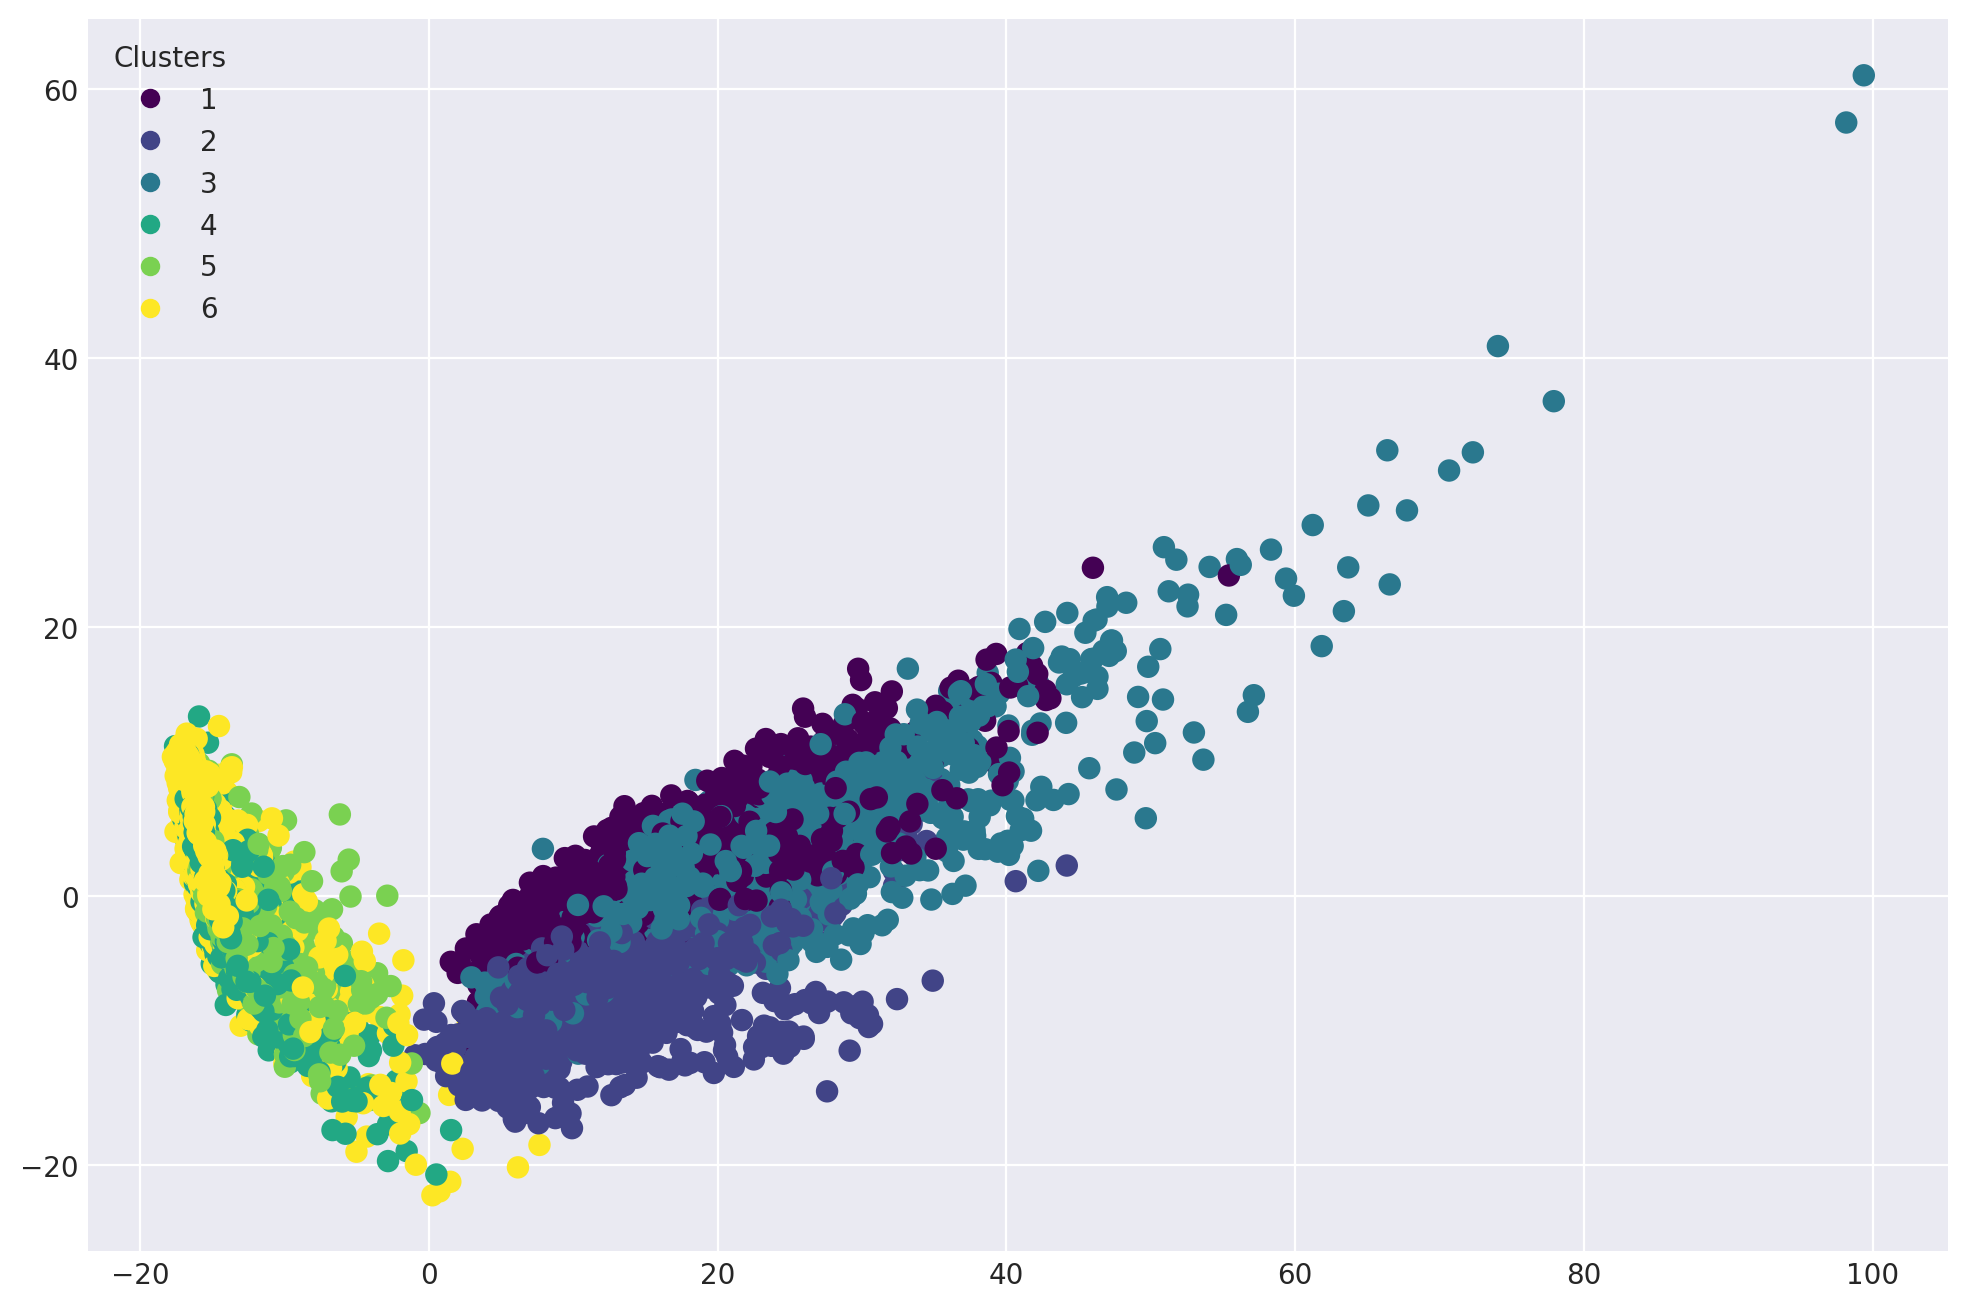

In [ ]:
plt.figure(figsize=(12,8))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=y, s=50, cmap='viridis')
plt.legend(handles=scatter.legend_elements()[0], labels=list(np.unique(y)), title='Clusters')
plt.show()

### **Задание 19. (0.5 балла)**

Разберёмся с `KMeans`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

- Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет `PCA` размерностью. Нужно искать 6 кластеров (изначально у нас 6 классов). Засеките время обучения и время инференса.

**Параметры обучения:**

```n_clusters = 6``` (число уникальных меток целевого класса = 6)

```n_init = 100```

```random_state = RANDOM_STATE``` (для воспроизводимости результата, не забывайте указывать его и дальше!)

In [ ]:
from sklearn.cluster import KMeans
import time

kmeans = KMeans(n_clusters=6, n_init=100, random_state=RANDOM_STATE)
start_time = time.time()
kmeans.fit(X_pca)
print(f"Время на обучение: {time.time() - start_time}")

Время на обучение: 19.85264015197754


### **Задание 20 (0.2 балла)**

- Визуализируйте данные в проекции на первые две главные компоненты.
- Раскрасьте точки в соответствии с полученными метками кластеров.

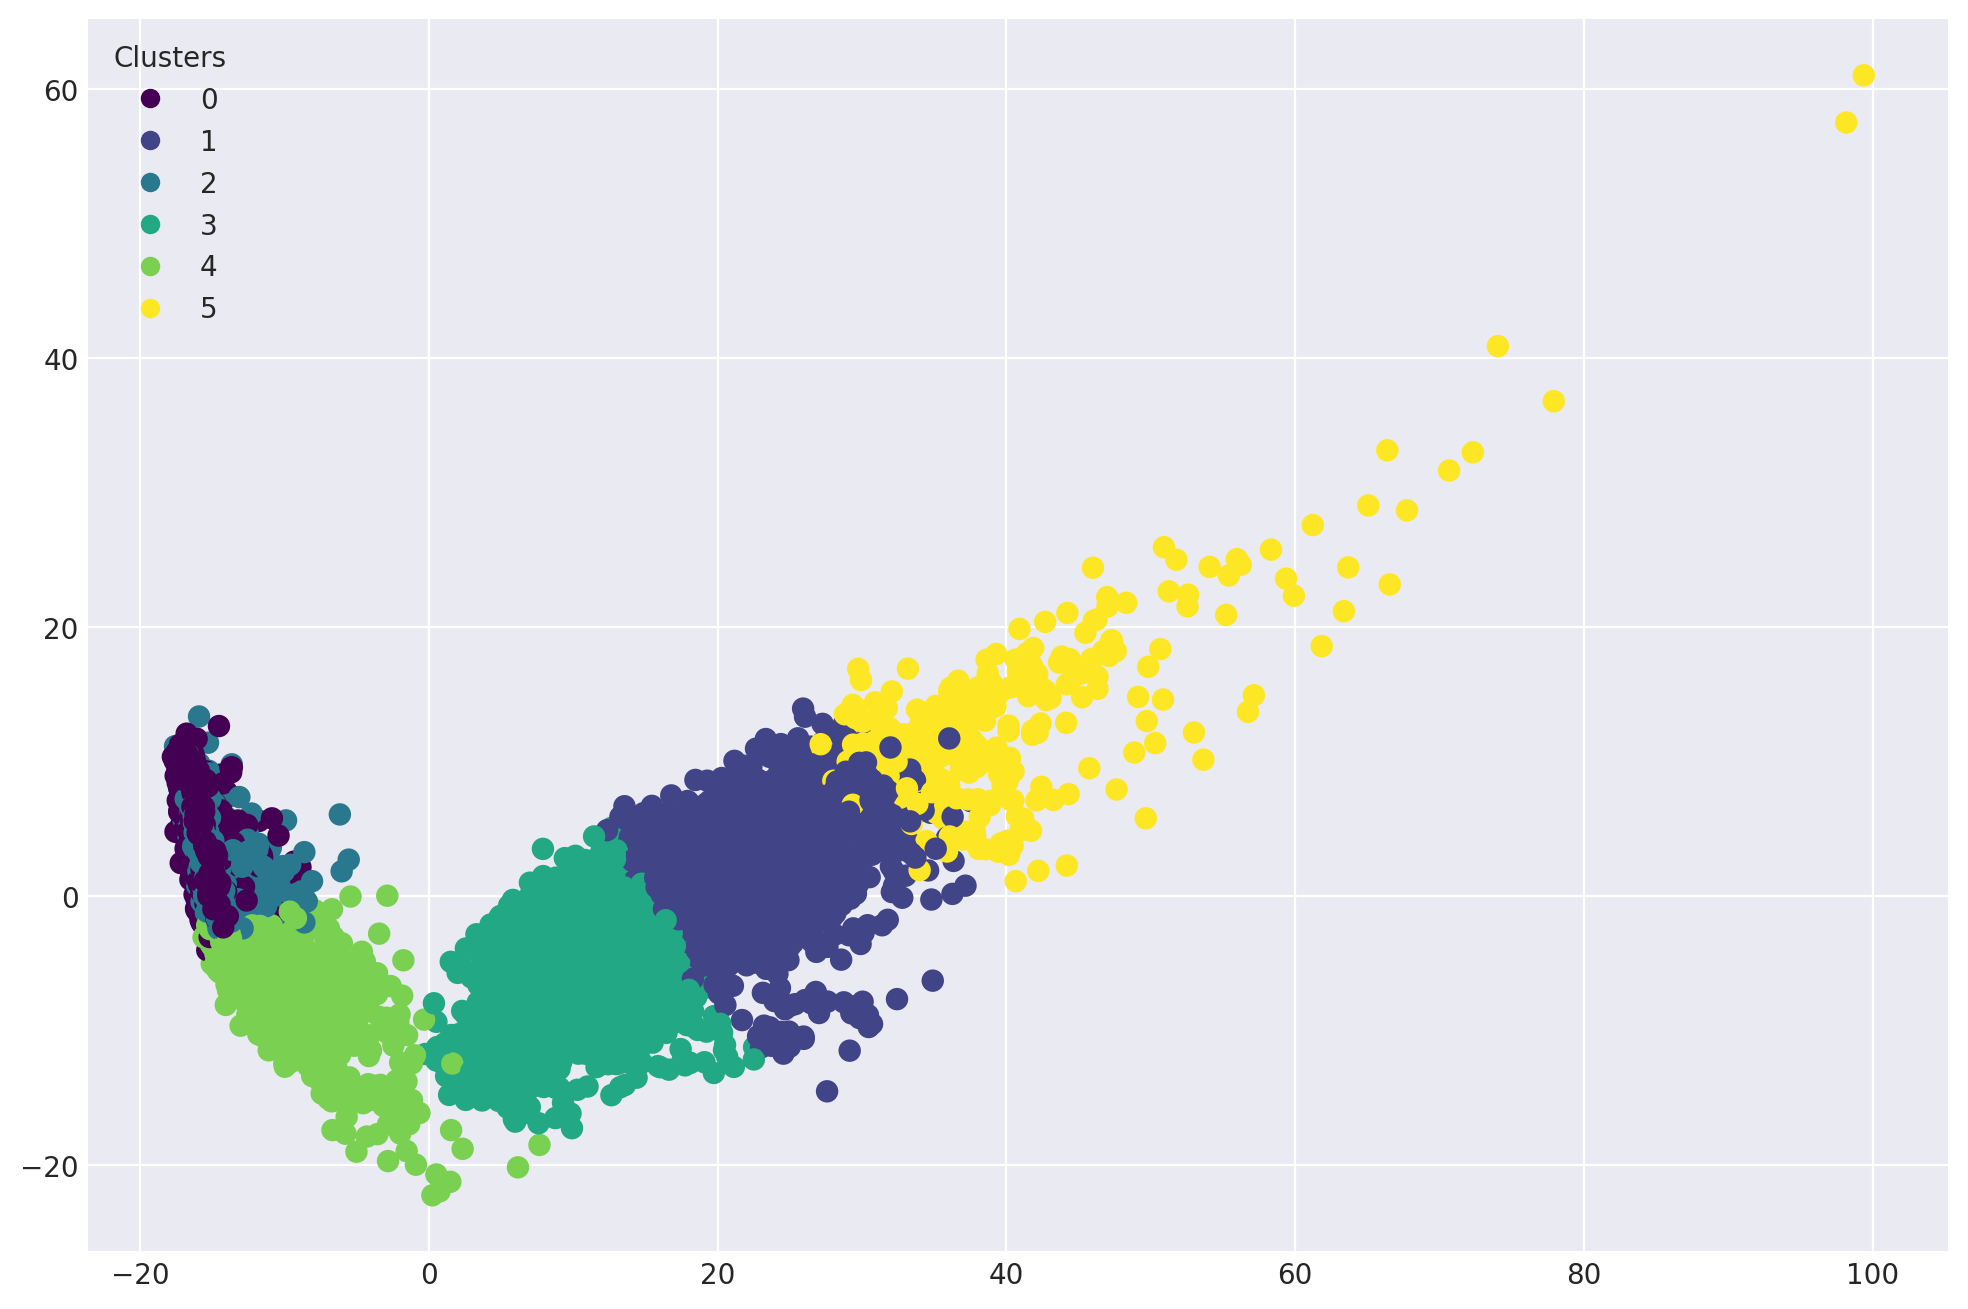

In [ ]:
plt.figure(figsize=(12,8))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=kmeans.labels_, s=50, cmap='viridis')
plt.legend(handles=scatter.legend_elements()[0], labels=list(np.unique(kmeans.labels_)), title='Clusters')
plt.show()

### **Задание 21 (0.3 балла)**

- Выберите какие-то метрики (минимум две) из известных вам. Объясните свой выбор
- Выведите на экран значения метрик качества, сделайте вывод о них и используйте их далее.

Выбрал гомогенность и полноту, чтобы понять, на сколько каждый кластер относится к одному классу и каждый класс к одному и тому же кластеру. Дополнительно выведу V-меру как среднее гармоническое значение полноты и однородности.   
Также выбрал силуэт, чтобы проверить качество кластеризации как таковой, без дополнительной информации о классах

In [ ]:
from sklearn.metrics import silhouette_score, homogeneity_completeness_v_measure

homogeneity_completeness_v_measure(y.to_numpy()[:,0], kmeans.labels_)

(0.5405702796626982, 0.5809669531868589, 0.5600410921019029)

**Вывод:** Гомогенность, полнота и V-мера имеют средние значения. Это говорит о том, что объекты из одного класса встречаются в разных кластерах и в одном кластере встречаются смешанные классы.   

In [ ]:
silhouette_score(y.to_numpy(), kmeans.labels_.reshape(-1, 1))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.13378145105976616

**Вывод:** Значение силуэта близко к нулю. Это говорит о том, что кластеры плохо разделены.

### **Задание 22 (0.7 баллов)**

Теперь попробуем сделать кластеризацию с помощью `AgglomerativeClustering`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

- Засеките время обучения и время инференса. После кластеризации также:
  - Вновь визуализируйте данные с раскраской по полученным меткам
  - Выведите метрики. Засеките время обучения и время инференса. Сравните с ```KMeans```.

Ответьте на следующие вопросы:
* Стало ли лучше?
* Почему?

In [ ]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering()
start_time = time.time()
clustering.fit(X_pca)
print(f"Время на обучение: {time.time() - start_time}")

Время на обучение: 15.75685739517212


Времени на обучение затрачено немного меньше, чем для KMean

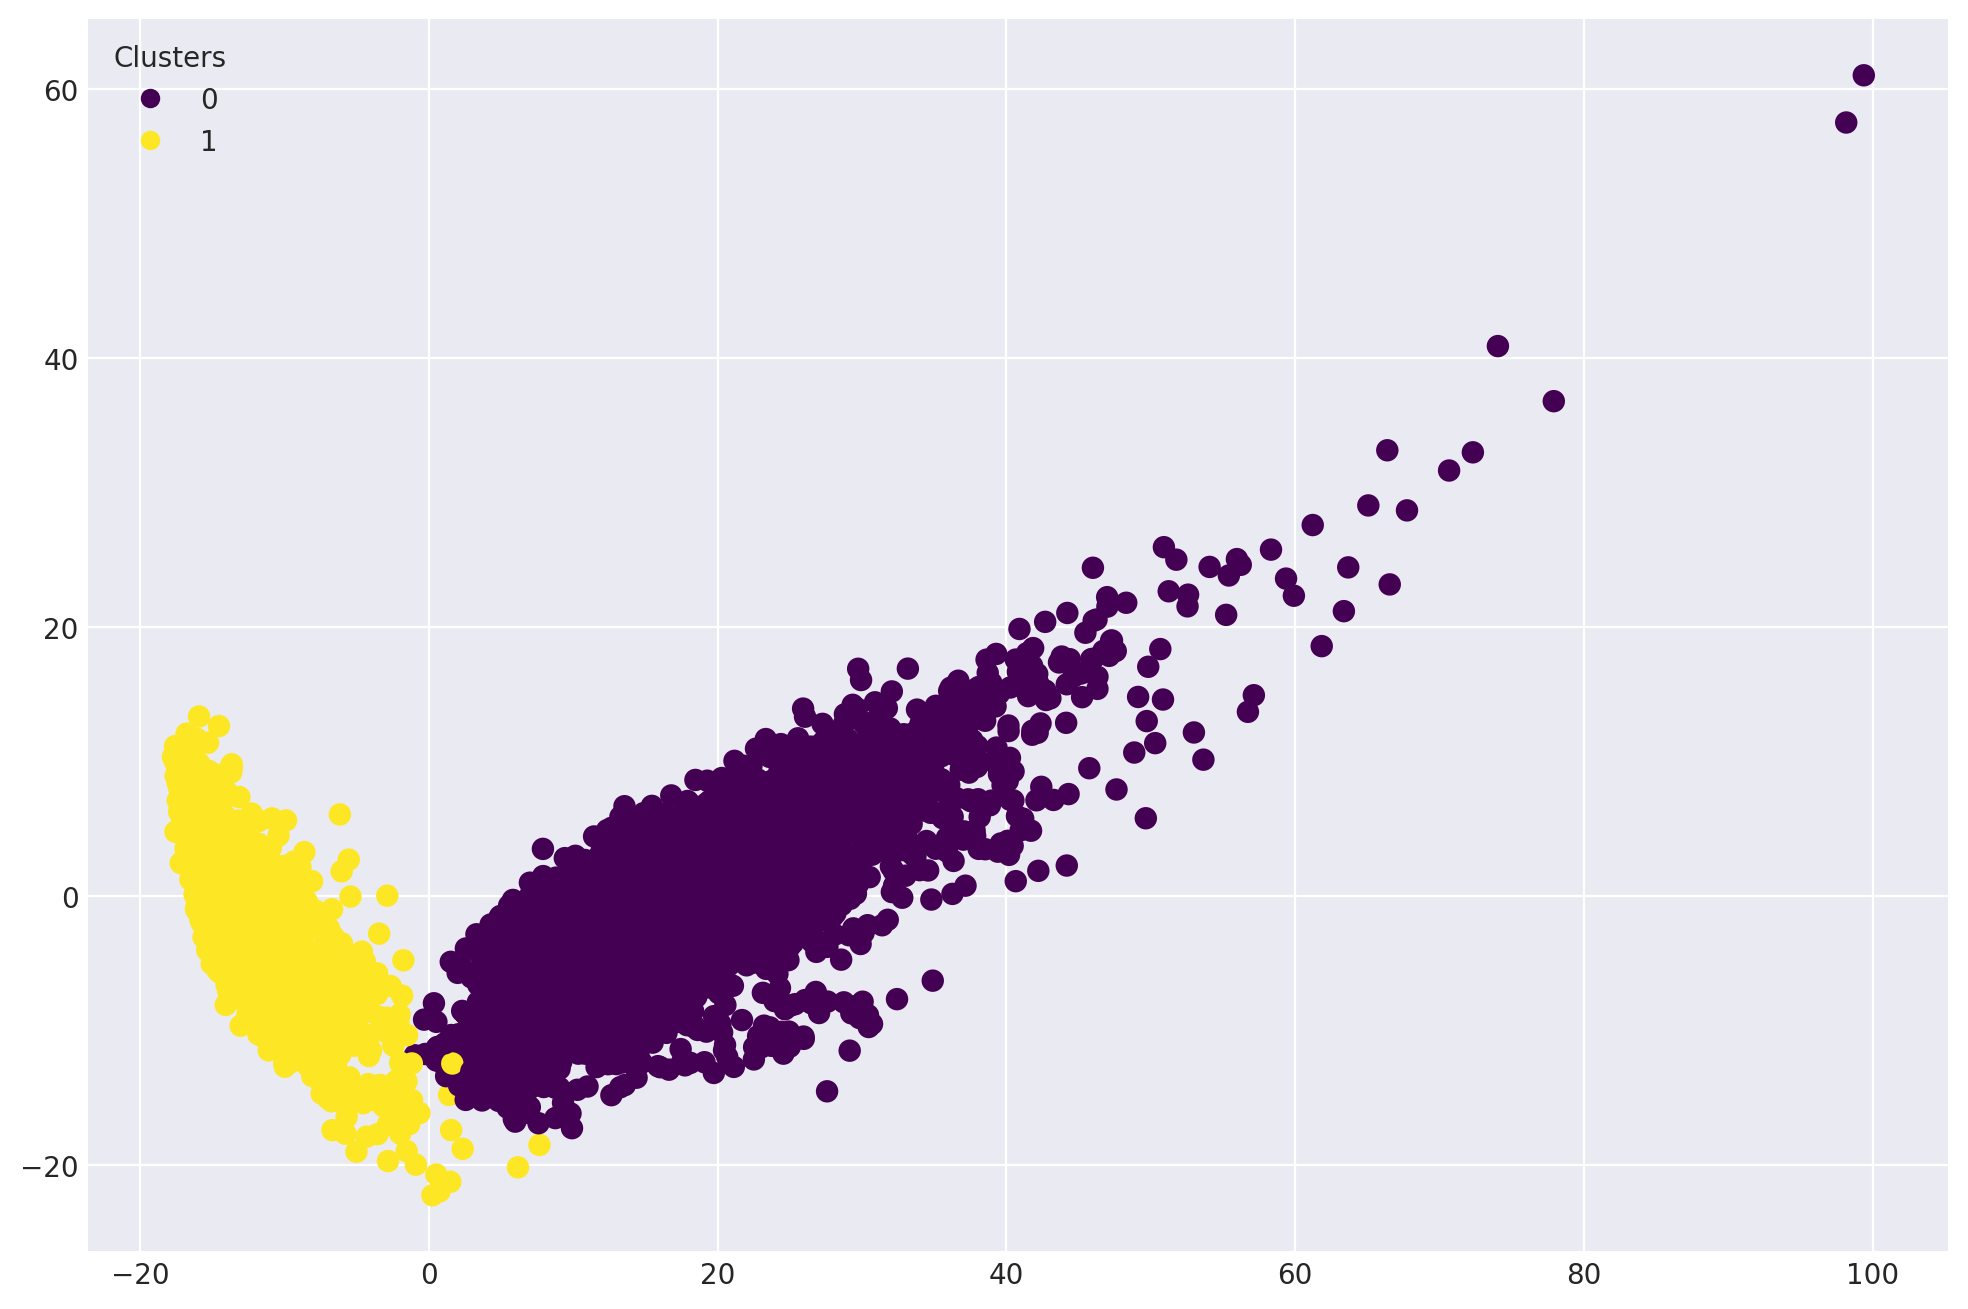

In [ ]:
plt.figure(figsize=(12,8))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=clustering.labels_, s=50, cmap='viridis')
plt.legend(handles=scatter.legend_elements()[0], labels=list(np.unique(clustering.labels_)), title='Clusters')
plt.show()

In [ ]:
homogeneity_completeness_v_measure(y.to_numpy()[:,0], clustering.labels_)

(0.38579907418430925, 0.9999999999999993, 0.5567893374606173)

In [ ]:
silhouette_score(y.to_numpy(), clustering.labels_.reshape(-1, 1))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6854667188475915

**Вывод:** Значительно улучшилось значение силуэта. Это говорит о том, что кластреры стали лучше разделены.  
Значение гомогенности стало хуже, это связано с тем, что кластеров стало всего 2, а изначальных классов - 6, поэтому несколько классов попали в один кластер.  
Полнота ~1, говорит о том, что все объекты одного класса попали в один кластер.  
V-мера стала немного хуже, чем для KMean, это связано с низкими значениями гомогенности.

### **Задание 23 (0.3 балла)**
Для самой успешной из полученных кластеризаций попробуйте дать интерпретацию кластеров. Опишите характеристики объектов, попавших в каждый кластер. Для этого можете ответить на следующие вопросы:

* Похожи ли объекты внутри каждого кластера на определенный тип активности человека?
* В каких кластерах смешано несколько типов активности? С чем, на ваш взгляд, это может быть связано?
* Качественная ли получилась кластеризация? На основании чего вы можете сделать такой вывод?

**Более успешная кластеризация - с использованием AgglomerativeClustering**, т.к. её силуэт показал значение значительно лучше, чем у KMean, а V-мера стала немного ниже, но осталась приблизительна равна в обоих методах кластеризации

**Вывод:** Основываясь на визуализации данных: для AgglomerativeClustering классы 1, 2, 3 попали в кластер 0, а классы 4, 5, 6 - в кластер 1.

**Ходьба, подъем вверх по лестнице и спуск по лестнице** попали в один кластер, а **сидение, стояние и лежание** в другой. Такое разделение выглядит логичным, т.к. данные разделены на те, где пользователь **куда-то движется** и на те, где пользователь **находится в покое**.  
Если рассматривать кластеризацию как разделение на "двигающихся" и "не двигающихся" пользователей, то классификация получилась отличная, т.к. полнота близка к единице и классы разделены на эти два кластера.

**Ваш вывод здесь**

## **Бонус-задание (1 балл)**
![RedPanda](http://imgur.com/6Aa52Lm.png)

Алгоритмы кластеризации могут применяться в самых разных задачах. Например, в анализе изображений есть задача разделения изображения на семантические компоненты, которую можно решать в том числе с помощью алгоритмов кластеризации. В бонусе предлагаем вам попрактиковаться именно в этом на чудесной утке и совах (```duck.jpg``` и ```owls.jpg```)

### **(0.1 балл)**

- Откройте изображения, после чего визуализируйте их с помощью ```plt.imshow()```

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

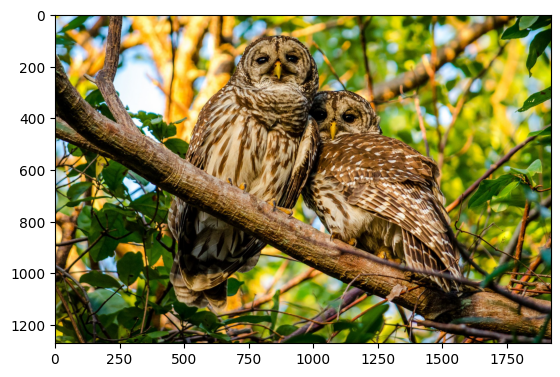

In [ ]:
img_owl = Image.open("./Owls.jpg")
plt.imshow(img_owl)
plt.show()

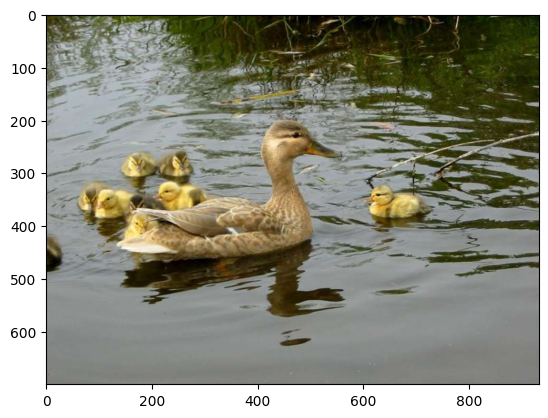

In [ ]:
img_duck = Image.open("./duck.jpg")
plt.imshow(img_duck)
plt.show()

### **(0.4 балла)**

Для каждого изображения, используя кластеризацию ```KMeans```, выделите компоненты, охарактеризовав каждый пиксель следующим образом: $$\psi_i = [\lambda x_i, \lambda y_i, r_i, g_i, b_i]$$
 где
- $x_i$ и $y_i$ — координаты пикселя,
- $r_i, g_i, b_i$ — его цвет,
- $\lambda$ — параметр, выражающий важность пространственной связности перед цветовой похожестью.

Примените полученную функцию, взяв следующие $\lambda$: 0.3 и 1.5 для ```duck.jpg``` и ```owls.jpg``` (или другие, но тогда с вас красивые результаты :) )

**Примечание:**
Число кластеров подберите разумным образом на свой вкус (в качестве нулевого приближения можно взять 3)

In [ ]:
from sklearn.cluster import KMeans

def find_components(image, lmbd, n_clusters):
    img = np.array(image)
    height, width, _ = img.shape
    components = []
    for y in range(height):
        for x in range(width):
            r, g, b = img[y, x]
            psi_i = [lmbd * x, lmbd * y, r, g, b]
            components.append(psi_i)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(components)
    labels = labels.reshape((height, width))
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    for l in range(n_clusters):
        plt.contour(labels == l, contours=1,
                    colors=[plt.cm.nipy_spectral(l / float(n_clusters)), ])
    plt.xticks(())
    plt.yticks(())
    plt.show()

<ipython-input-14-c12085d9ac1a>:19: UserWarning: The following kwargs were not used by contour: 'contours'
  plt.contour(labels == l, contours=1,


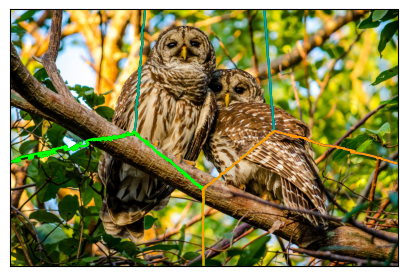

<ipython-input-14-c12085d9ac1a>:19: UserWarning: The following kwargs were not used by contour: 'contours'
  plt.contour(labels == l, contours=1,


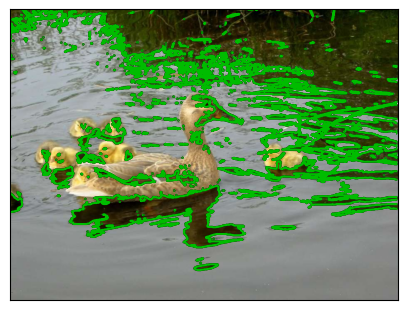

In [ ]:
owl_labels = find_components(img_owl, 1.5, 5)
duck_labels = find_components(img_duck, 0.3, 2)

KMeans удается выделить кластеры на изображении уток (хотя из-за бликов на воде и пестрости утки выделяет плохо), на изображении сов приктически ничего не выделяет (скорее всего, по той же причине).

### **(0.4 балла)**

Попробуйте выделить сегменты при помощи [спектральной кластеризации](http://scikit-learn.org/stable/modules/clustering.html#spectral-clustering). Обратите внимание на [пример в sklearn](http://scikit-learn.org/0.16/auto_examples/cluster/plot_lena_segmentation.html).


**Примечание:**

Для ускорения работы алгоритма рекомендуется привести изображение к серому цвету. При необходимости можно сжать изображения в 2 раза.

**Подсказка:**```skimage``` с его ```color``` и ```transform``` в этом помогут :)

Или же воспользуйтесь аналогичными средствами ```PIL``` или ```cv2```

Метод работает очень долго, поэтому изображение уменьшаю в 4 раза

In [ ]:
from sklearn.cluster import spectral_clustering
from sklearn.feature_extraction import image
from skimage.color import rgb2gray
from skimage.transform import rescale

def spectral_segmentation(img, n_clusters, beta, eps):
    img_gray = rescale(rgb2gray(img), 0.25)
    graph = image.img_to_graph(img_gray)
    graph.data = np.exp(-beta * graph.data / img_gray.std()) + eps
    labels = spectral_clustering(graph, n_clusters=n_clusters, random_state=42)
    labels = labels.reshape(img_gray.shape)

    plt.figure(figsize=(5, 5))
    plt.imshow(img_gray)
    for l in range(n_clusters):
        plt.contour(labels == l, contours=1,
                    colors=[plt.cm.nipy_spectral(l / float(n_clusters)), ])
    plt.xticks(())
    plt.yticks(())
    plt.show()

<ipython-input-32-e0faa06760f0>:16: UserWarning: The following kwargs were not used by contour: 'contours'
  plt.contour(labels == l, contours=1,


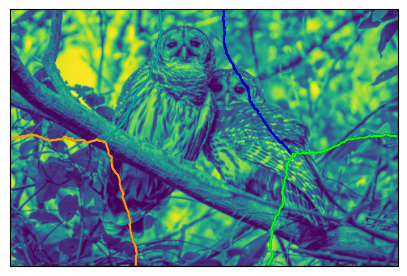

In [ ]:
beta = 3
eps = 1e-6
owl_labels = spectral_segmentation(img_owl, 5, beta, eps)

<ipython-input-32-e0faa06760f0>:16: UserWarning: The following kwargs were not used by contour: 'contours'
  plt.contour(labels == l, contours=1,


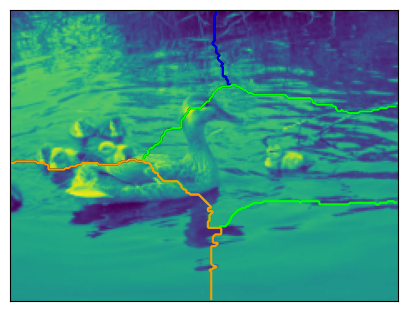

In [ ]:
duck_labels = spectral_segmentation(img_duck, 5, beta, eps)

Спектральная кластеризация работает долго. Визуально заметно, что кластеризация пытается выделить части на изображении, но плохо работает с маленьким разбиением на кластеры.

### **(0.1 балл)**
Визуализируйте результаты сегментации (аналогично рисунку в начале задания 2) для обоих методов.

Визуализации добавлены в методы и показаны выше

In [ ]:
# Визуализации добавлены в методы и показаны выше

**Спасибо! Вы — человек — большой трудяга!**

Успокоительный котобонус :)

Ответ: **Считаю, что это питомец Сабрины**

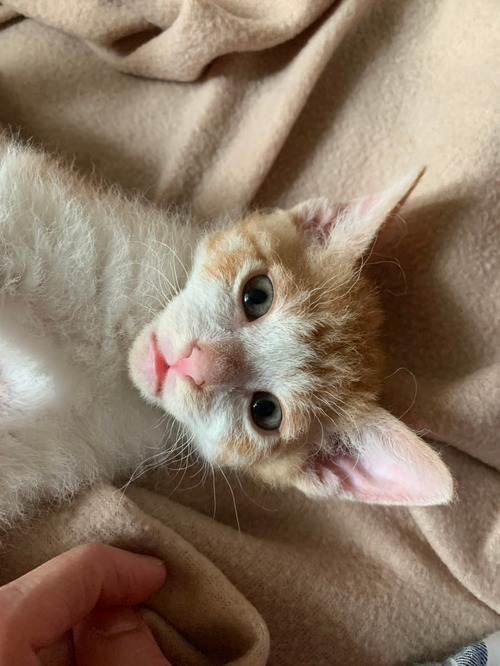